In [8]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import sklearn as sk
import matplotlib as mpl
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score,f1_score,accuracy_score
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.ensemble import RandomForestClassifier as RF
import lightgbm as lgb
from xgboost import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import PolynomialFeatures
from catboost import Pool,CatBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import svm, model_selection,tree, linear_model, neighbors, naive_bayes, ensemble 
from sklearn import discriminant_analysis, gaussian_process

In [9]:
X = pd.read_csv('training_set_features.csv')
Y = pd.read_csv('training_set_labels.csv')

In [10]:
print('Shape of X: ',X.shape)
print('Shape of Y: ',Y.shape)

Shape of X:  (26707, 36)
Shape of Y:  (26707, 3)


In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [12]:
X.head()

respondent_id  h1n1_concern  h1n1_knowledge  behavioral_antiviral_meds  \
0              0           1.0             0.0                        0.0   
1              1           3.0             2.0                        0.0   
2              2           1.0             1.0                        0.0   
3              3           1.0             1.0                        0.0   
4              4           2.0             1.0                        0.0   

   behavioral_avoidance  behavioral_face_mask  behavioral_wash_hands  \
0                   0.0                   0.0                    0.0   
1                   1.0                   0.0                    1.0   
2                   1.0                   0.0                    0.0   
3                   1.0                   0.0                    1.0   
4                   1.0                   0.0                    1.0   

   behavioral_large_gatherings  behavioral_outside_home  \
0                          0.0                      1.0   
1                          0.0                      1.0   
2                          0.0                      0.0   
3                          1.0                      0.0   
4                          1.0                      0.0   

   behavioral_touch_face  ...             income_poverty  marital_status  \
0                    1.0  ...              Below Poverty     Not Married   
1                    1.0  ...              Below Poverty     Not Married   
2                    0.0  ...  <= $75,000, Above Poverty     Not Married   
3                    0.0  ...              Below Poverty     Not Married   
4                    1.0  ...  <= $75,000, Above Poverty         Married   

   rent_or_own   employment_status  hhs_geo_region                census_msa  \
0          Own  Not in Labor Force        oxchjgsf                   Non-MSA   
1         Rent            Employed        bhuqouqj  MSA, Not Principle  City   
2          Own            Employed        qufhixun  MSA, Not Principle  City   
3         Rent  Not in Labor Force        lrircsnp       MSA, Principle City   
4          Own            Employed        qufhixun  MSA, Not Principle  City   

   household_adults  household_children  employment_industry  \
0               0.0                 0.0                  NaN   
1               0.0                 0.0             pxcmvdjn   
2               2.0                 0.0             rucpziij   
3               0.0                 0.0                  NaN   
4               1.0                 0.0             wxleyezf   

   employment_occupation  
0                    NaN  
1               xgwztkwe  
2               xtkaffoo  
3                    NaN  
4               emcorrxb  

[5 rows x 36 columns]

In [13]:
X.columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation'],
      dtype='object')

In [14]:
Z = Y
Z.drop('respondent_id',axis = 1,inplace = True)
frames = [X,Z]
data = pd.concat(frames,axis=1)

In [15]:
data.isnull().sum()

respondent_id                      0
h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
m

In [16]:
# close to half the values of these columns are NULL so discarding
data.drop(['health_insurance','employment_industry','employment_occupation'],axis=1,inplace = True)

In [20]:
sns.barplot('h1n1_vaccine',data=Y,kind='count',size = 3.5)
sns.barplot('seasonal_vaccine',data=Y,kind='count',size = 3.5)

TypeError: barplot() got multiple values for argument 'data'

In [21]:
str_cols = data.select_dtypes(include = 'object').columns
data[str_cols].head()

age_group         education   race     sex             income_poverty  \
0  55 - 64 Years        < 12 Years  White  Female              Below Poverty   
1  35 - 44 Years          12 Years  White    Male              Below Poverty   
2  18 - 34 Years  College Graduate  White    Male  <= $75,000, Above Poverty   
3      65+ Years          12 Years  White  Female              Below Poverty   
4  45 - 54 Years      Some College  White  Female  <= $75,000, Above Poverty   

  marital_status rent_or_own   employment_status hhs_geo_region  \
0    Not Married         Own  Not in Labor Force       oxchjgsf   
1    Not Married        Rent            Employed       bhuqouqj   
2    Not Married         Own            Employed       qufhixun   
3    Not Married        Rent  Not in Labor Force       lrircsnp   
4        Married         Own            Employed       qufhixun   

                 census_msa  
0                   Non-MSA  
1  MSA, Not Principle  City  
2  MSA, Not Principle  City  
3       MSA, Principle City  
4  MSA, Not Principle  City

In [22]:
# All the NULL values are populated with the mode
for col in data.columns:
    if data[col].isnull().sum() and data[col].dtypes != 'object':
        data[col].loc[(X[col].isnull())] = data[col].median()
for col in data.columns:
    if data[col].isnull().sum() and data[col].dtypes == 'object':
        data[col].loc[(data[col].isnull())] = data[col].mode().max()

In [23]:
data.isnull().sum()

respondent_id                  0
h1n1_concern                   0
h1n1_knowledge                 0
behavioral_antiviral_meds      0
behavioral_avoidance           0
behavioral_face_mask           0
behavioral_wash_hands          0
behavioral_large_gatherings    0
behavioral_outside_home        0
behavioral_touch_face          0
doctor_recc_h1n1               0
doctor_recc_seasonal           0
chronic_med_condition          0
child_under_6_months           0
health_worker                  0
opinion_h1n1_vacc_effective    0
opinion_h1n1_risk              0
opinion_h1n1_sick_from_vacc    0
opinion_seas_vacc_effective    0
opinion_seas_risk              0
opinion_seas_sick_from_vacc    0
age_group                      0
education                      0
race                           0
sex                            0
income_poverty                 0
marital_status                 0
rent_or_own                    0
employment_status              0
hhs_geo_region                 0
census_msa

In [24]:
LE = LabelEncoder()
for col in str_cols:
    data[col] = LE.fit_transform(data[col]) # Converts to int64

In [25]:
data[str_cols].head()

age_group  education  race  sex  income_poverty  marital_status  \
0          3          1     3    0               2               1   
1          1          0     3    1               2               1   
2          0          2     3    1               0               1   
3          4          0     3    0               2               1   
4          2          3     3    0               0               0   

   rent_or_own  employment_status  hhs_geo_region  census_msa  
0            0                  1               8           2  
1            1                  0               1           0  
2            0                  0               9           0  
3            1                  1               5           1  
4            0                  0               9           0

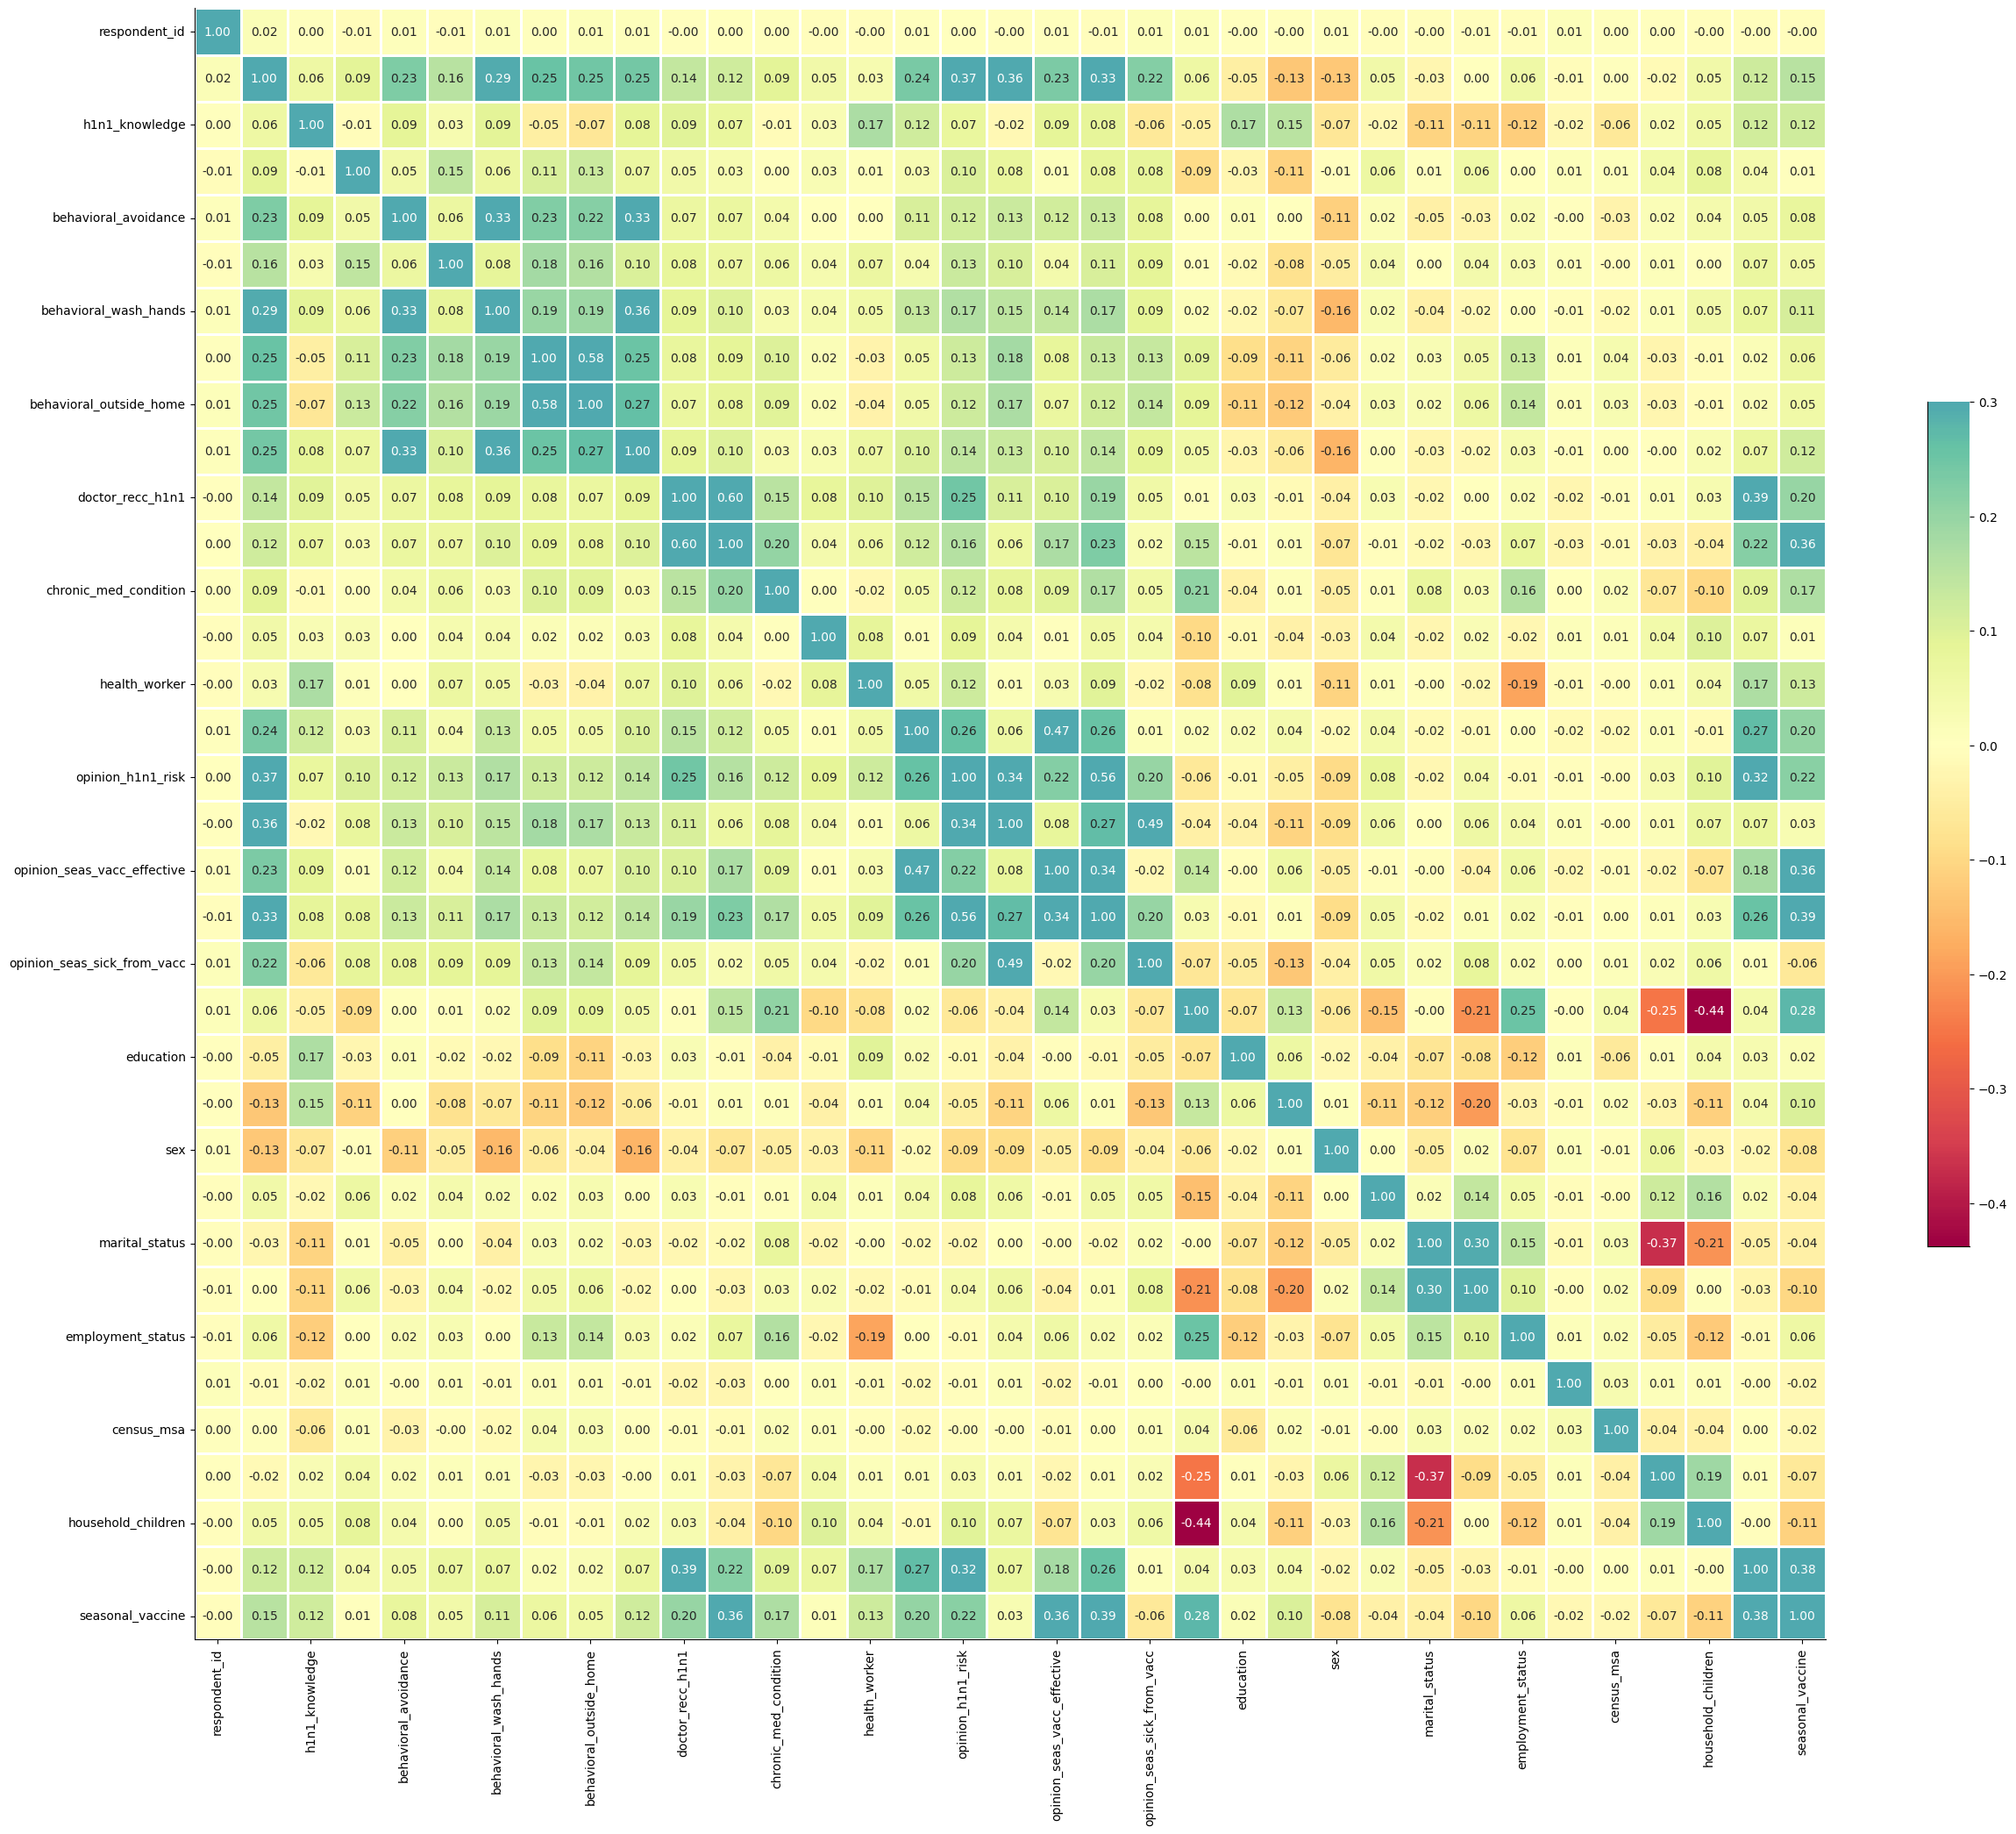

In [26]:
corr = data.corr()
g = sns.heatmap(corr,  vmax=.3, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='Spectral')
sns.despine()
g.figure.set_size_inches(30,25)
    
plt.show()

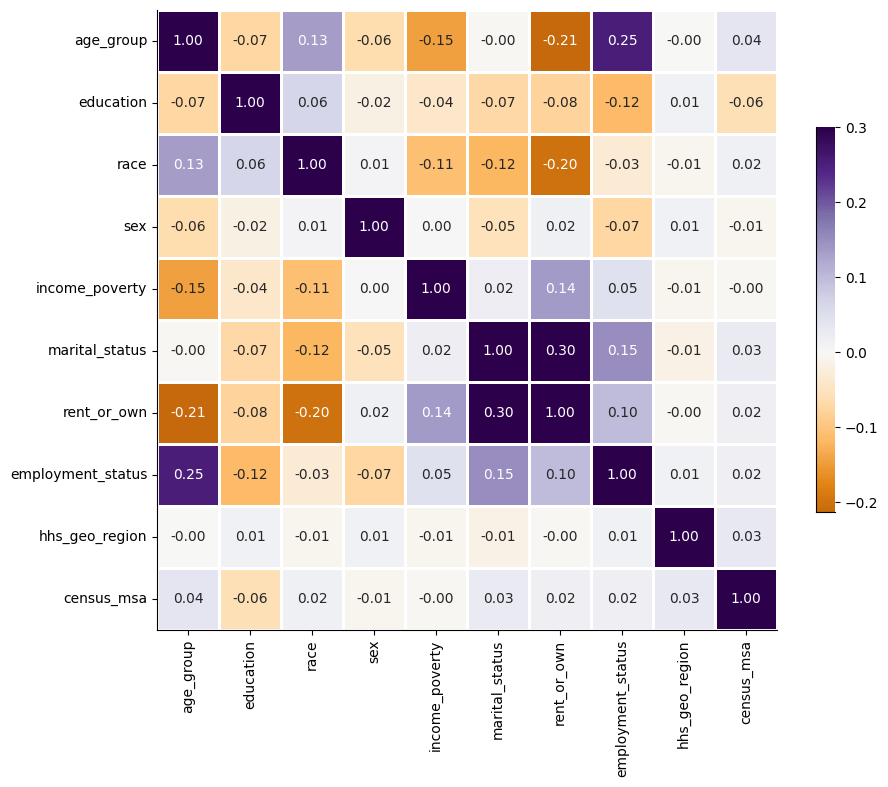

In [27]:
datum = data[str_cols]
corr = datum.corr()
g = sns.heatmap(corr,  vmax=.3, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='PuOr')
sns.despine()
g.figure.set_size_inches(10,10)
    
plt.show()

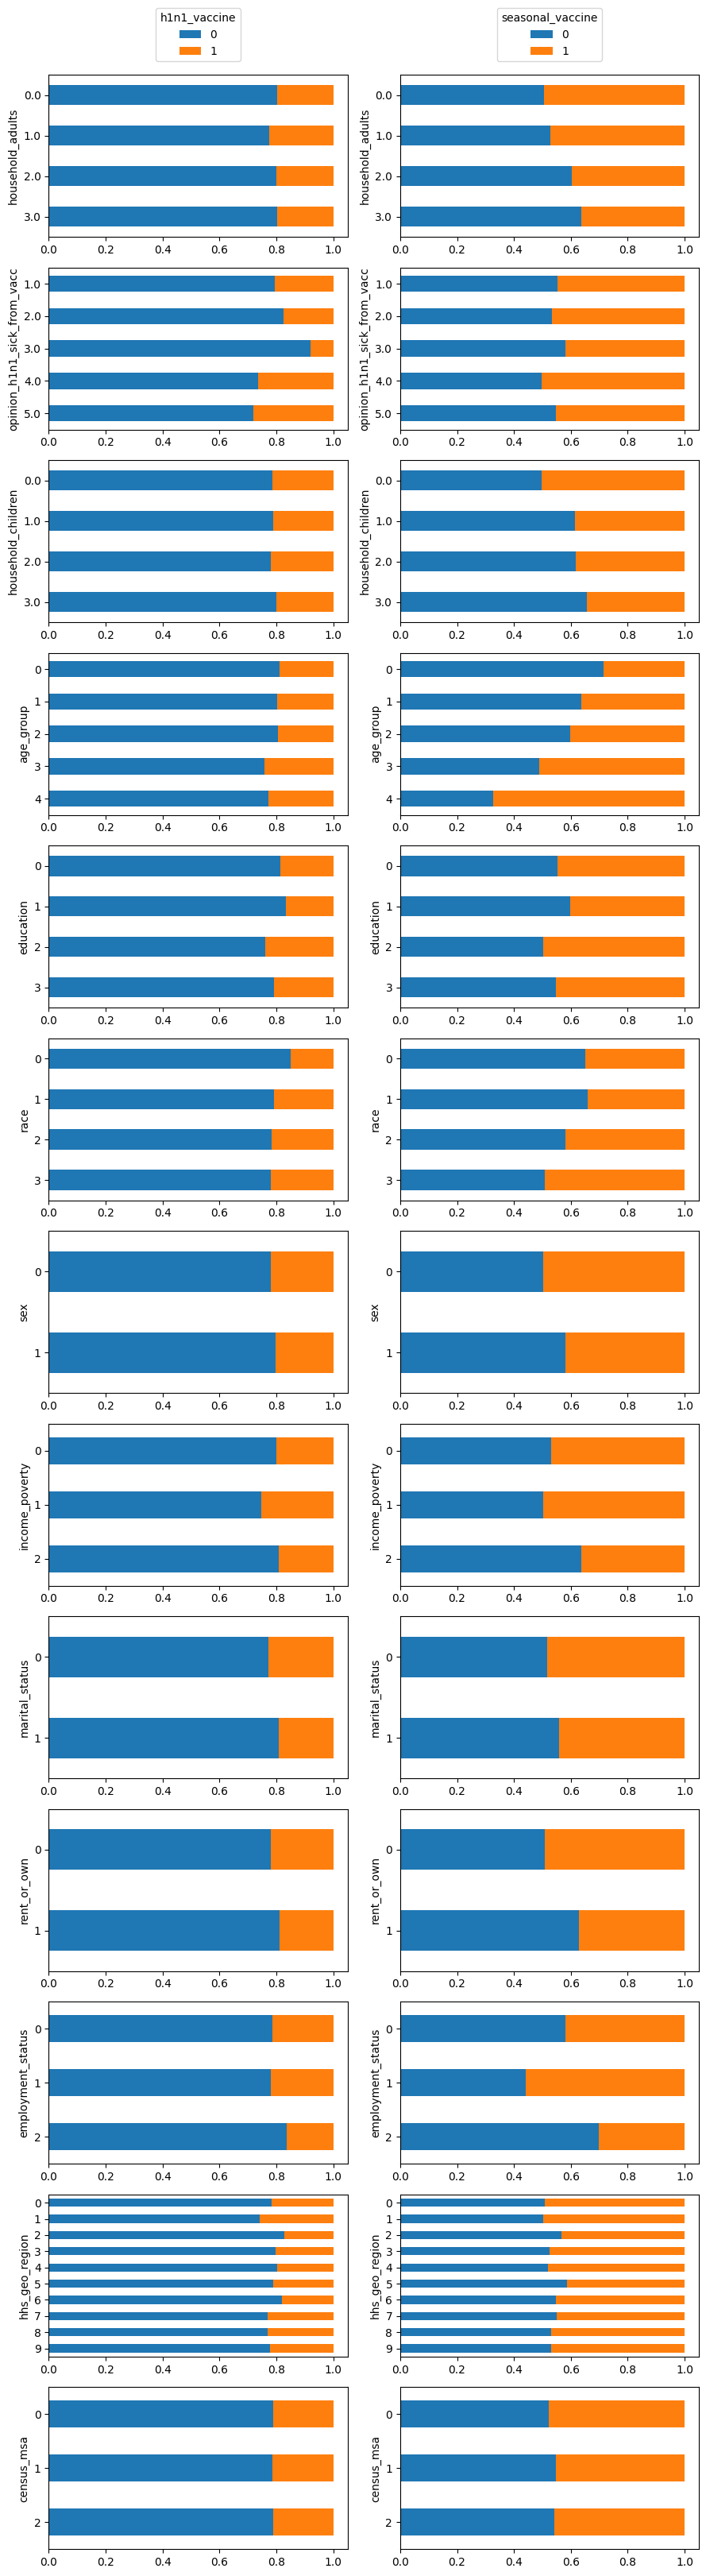

In [28]:
def vaccination_rate_plot(col, target, data, ax=None):
    """Stacked bar chart of vaccination rate for `target` against 
    `col`. 
    
    Args:
        col (string): column name of feature variable
        target (string): column name of target variable
        data (pandas DataFrame): dataframe that contains columns 
            `col` and `target`
        ax (matplotlib axes object, optional): matplotlib axes 
            object to attach plot to
    """
    counts = (data[[target, col]]
                  .groupby([target, col])
                  .size()
                  .unstack(target)
             )
    group_counts = counts.sum(axis='columns')
    props = counts.div(group_counts, axis='index')

    props.plot(kind="barh", stacked=True, ax=ax)
    ax.invert_yaxis()
    ax.legend().remove()

cols_to_plot = [
     'household_adults','opinion_h1n1_sick_from_vacc',
       'household_children', 'age_group', 'education', 'race',
       'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region',
       'census_msa'
       
]

fig, ax = plt.subplots(
    len(cols_to_plot), 2, figsize=(9,len(cols_to_plot)*2.5)
)
for idx, col in enumerate(cols_to_plot):
    vaccination_rate_plot(
        col, 'h1n1_vaccine', data, ax=ax[idx, 0]
    )
    vaccination_rate_plot(
        col, 'seasonal_vaccine', data, ax=ax[idx, 1]
    )
    
ax[0, 0].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='h1n1_vaccine'
)
ax[0, 1].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine'
)
fig.tight_layout()

In [29]:
## The gender distribution of the data
sns.factorplot('sex',data=data,kind='count',size = 3.5)

## The number of people in each category of concern
sns.factorplot('h1n1_concern',kind = 'count',data = data)

AttributeError: module 'seaborn' has no attribute 'factorplot'

In [ ]:
sns.factorplot('h1n1_knowledge',kind = 'count',data = data)
sns.factorplot('hhs_geo_region',kind = 'count',data = data)

In [ ]:
sns.factorplot('race',kind = 'count',data = data)
sns.factorplot('education',kind = 'count',data = data)

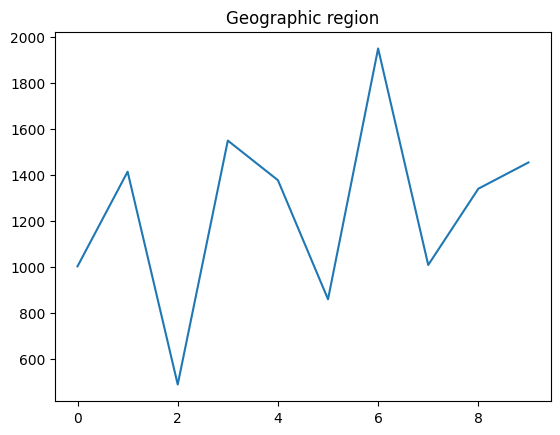

In [30]:
df = data[data["seasonal_vaccine"] == 1].groupby(data['hhs_geo_region']).sum()
plt.title('Geographic region')
plt.plot(df['seasonal_vaccine'])
plt.show()
### people living in geographic regions 1,3,6 are more likely to get vaccinated than the rest

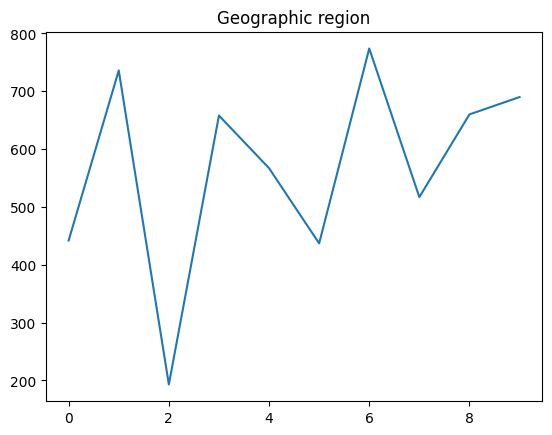

In [31]:
df = data[data["h1n1_vaccine"] == 1].groupby(data['hhs_geo_region']).sum()
plt.title('Geographic region')
plt.plot(df['h1n1_vaccine'])
plt.show()

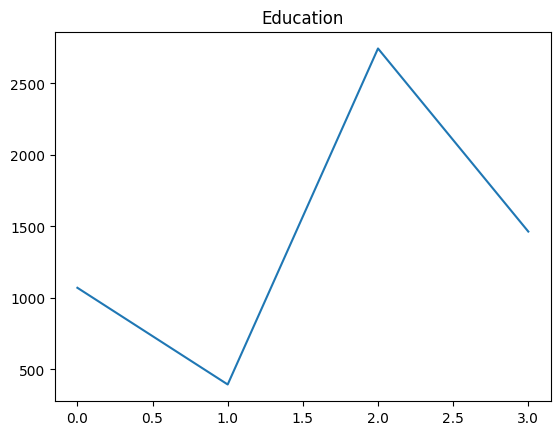

In [32]:
df = data[data["h1n1_vaccine"] == 1].groupby(data['education']).sum()
plt.title('Education')
plt.plot(df['h1n1_vaccine'])
plt.show()

In [33]:
data['cleanliness'] =  data['behavioral_antiviral_meds']+ data['behavioral_avoidance']+\
                        data['behavioral_face_mask']+data['behavioral_wash_hands']+\
                       data['behavioral_large_gatherings'] + data['behavioral_outside_home']+\
                       data['behavioral_touch_face']

In [34]:
data['cleanliness']

0        2.0
1        4.0
2        1.0
3        3.0
4        4.0
        ... 
26702    2.0
26703    2.0
26704    5.0
26705    1.0
26706    1.0
Name: cleanliness, Length: 26707, dtype: float64

In [35]:
sns.factorplot('cleanliness',kind = 'count',data = data)

AttributeError: module 'seaborn' has no attribute 'factorplot'

In [37]:
print(data[data["h1n1_vaccine"]==1].count()[1])

5674


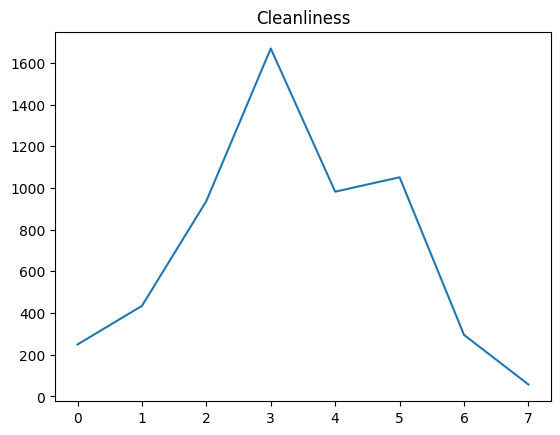

In [38]:
df = data[data["h1n1_vaccine"] == 1].groupby(data['cleanliness']).sum()
plt.title('Cleanliness')
plt.plot(df['h1n1_vaccine'])
plt.show()

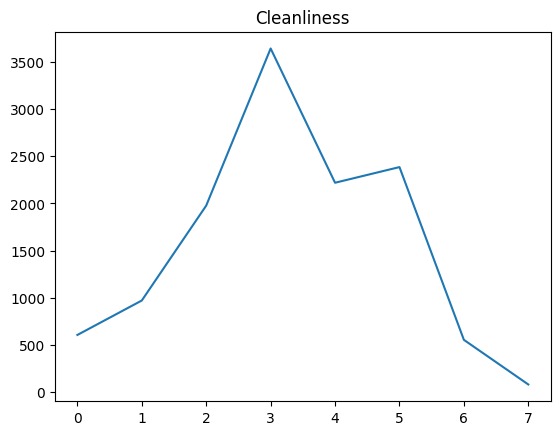

In [39]:
df = data[data["seasonal_vaccine"] == 1].groupby(data['cleanliness']).sum()
plt.title('Cleanliness')
plt.plot(df['seasonal_vaccine'])
plt.show()

In [40]:
data['opinion'] = data['opinion_h1n1_vacc_effective'] + data['opinion_h1n1_risk']+\
                  data['opinion_h1n1_sick_from_vacc'] + data['opinion_seas_vacc_effective']+\
                  data['opinion_seas_risk'] + data['opinion_seas_sick_from_vacc']

In [41]:
sns.factorplot('opinion',kind = 'count',data = data,size=9)

AttributeError: module 'seaborn' has no attribute 'factorplot'

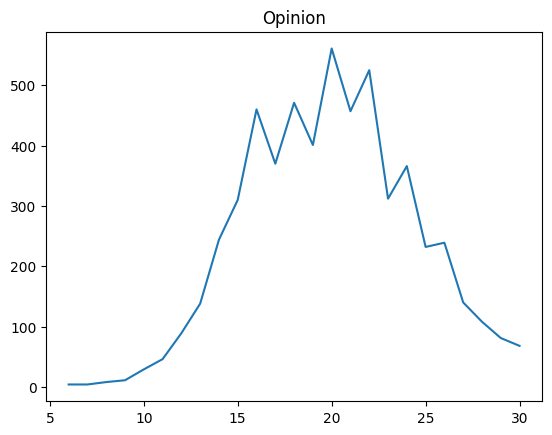

In [42]:
df = data[data["h1n1_vaccine"] == 1].groupby(data['opinion']).sum()
plt.title('Opinion')
plt.plot(df['h1n1_vaccine'])
plt.show()

In [43]:
data['opinion_h1n1'] = data['opinion_h1n1_vacc_effective'] + data['opinion_h1n1_risk']-\
                  data['opinion_h1n1_sick_from_vacc'] 
data['opinion_seasonal'] = data['opinion_seas_vacc_effective']+\
                  data['opinion_seas_risk'] - data['opinion_seas_sick_from_vacc']

In [44]:
data['concern>=2'] = np.where(data['h1n1_concern']>=2,1,0) 
# Since those who have concern>=2 have a pronounced effect on vaccination

data['good_opinion_vacc'] = np.where(data['opinion_seas_vacc_effective'] == 3,1,0)
#If the opinion is 3 it means he/she has a good opinion and is more likely to take the vaccine

data['good_knowledge'] = np.where(data['h1n1_knowledge'] == 2,1,0)
#Same kind of logic as mentioned previously

In [45]:
data['risk'] = np.where(data['opinion_h1n1_risk']>=4,1,0)

#data['sick'] = np.where(data['opinion_h1n1_sick_from_vacc'] == 3,1,0)

### Generating a column combining concern and knowledge, since they have seemingly good correlations!

data['concern_knowledge'] = data['h1n1_concern']+data['h1n1_knowledge']

## square of age group to subtely improve the correlation of that feature with the vaccine probabilty
data['a^2'] = data['age_group']*data['age_group']

In [46]:
data.columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'h1n1_vaccine',
       'seasonal_vaccine', 'cleanliness', 'opinion', 'opinion_h1n1',
       'opinion_seasonal', 'concern>=2', 'good_opinion_vacc', 'good_knowledge',
       'risk', 'concern_knowledge', 'a^2'],
      dt

In [47]:
data.head()

respondent_id  h1n1_concern  h1n1_knowledge  behavioral_antiviral_meds  \
0              0           1.0             0.0                        0.0   
1              1           3.0             2.0                        0.0   
2              2           1.0             1.0                        0.0   
3              3           1.0             1.0                        0.0   
4              4           2.0             1.0                        0.0   

   behavioral_avoidance  behavioral_face_mask  behavioral_wash_hands  \
0                   0.0                   0.0                    0.0   
1                   1.0                   0.0                    1.0   
2                   1.0                   0.0                    0.0   
3                   1.0                   0.0                    1.0   
4                   1.0                   0.0                    1.0   

   behavioral_large_gatherings  behavioral_outside_home  \
0                          0.0                      1.0   
1                          0.0                      1.0   
2                          0.0                      0.0   
3                          1.0                      0.0   
4                          1.0                      0.0   

   behavioral_touch_face  ...  cleanliness  opinion  opinion_h1n1  \
0                    1.0  ...          2.0     11.0           2.0   
1                    1.0  ...          4.0     23.0           5.0   
2                    0.0  ...          1.0     12.0           3.0   
3                    0.0  ...          3.0     21.0           1.0   
4                    1.0  ...          4.0     16.0           4.0   

   opinion_seasonal  concern>=2  good_opinion_vacc  good_knowledge  risk  \
0               1.0           0                  0               0     0   
1               2.0           1                  0               1     1   
2               3.0           0                  0               0     0   
3               8.0           0                  0               0     0   
4               0.0           1                  1               0     0   

   concern_knowledge  a^2  
0                1.0    9  
1                5.0    1  
2                2.0    0  
3                2.0   16  
4                3.0    4  

[5 rows x 45 columns]

In [48]:
##### Removing seemingly irrelevant features ######

data.drop(['race','child_under_6_months','opinion_h1n1_sick_from_vacc','opinion_seas_sick_from_vacc','household_adults','behavioral_antiviral_meds','behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_antiviral_meds','marital_status',
           'behavioral_avoidance','behavioral_face_mask','income_poverty','hhs_geo_region','employment_status','education','census_msa'],axis=1,inplace = True)

Y_label = data[['h1n1_vaccine','seasonal_vaccine']]

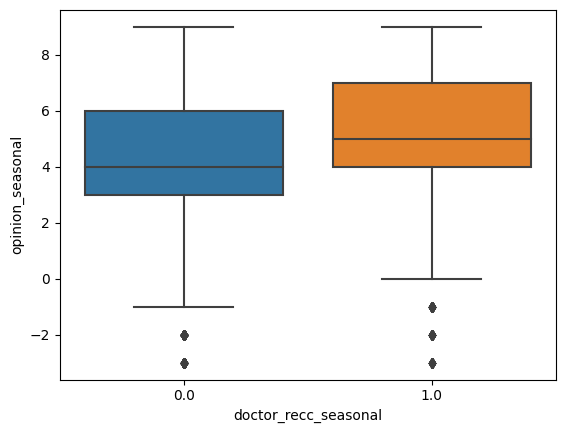

In [49]:
ax = sns.boxplot(x="doctor_recc_seasonal", y="opinion_seasonal", data=data)

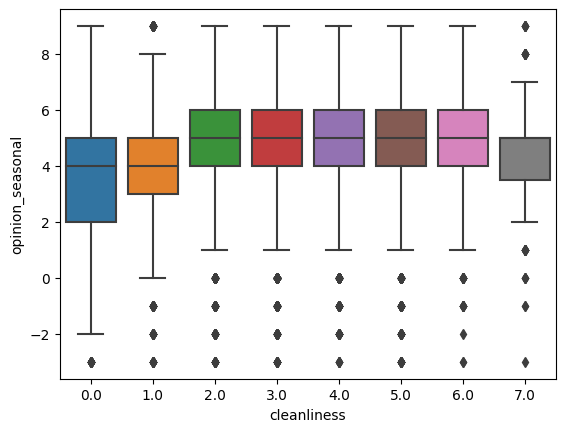

In [50]:
ax = sns.boxplot(x="cleanliness", y="opinion_seasonal", data=data)

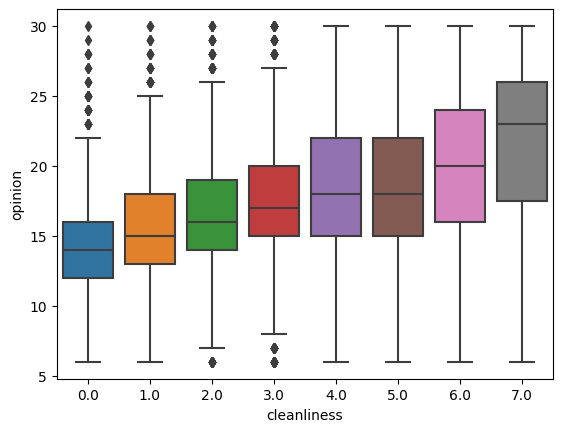

In [51]:
ax = sns.boxplot(x="cleanliness", y="opinion", data=data)

In [52]:
data.shape

(26707, 29)

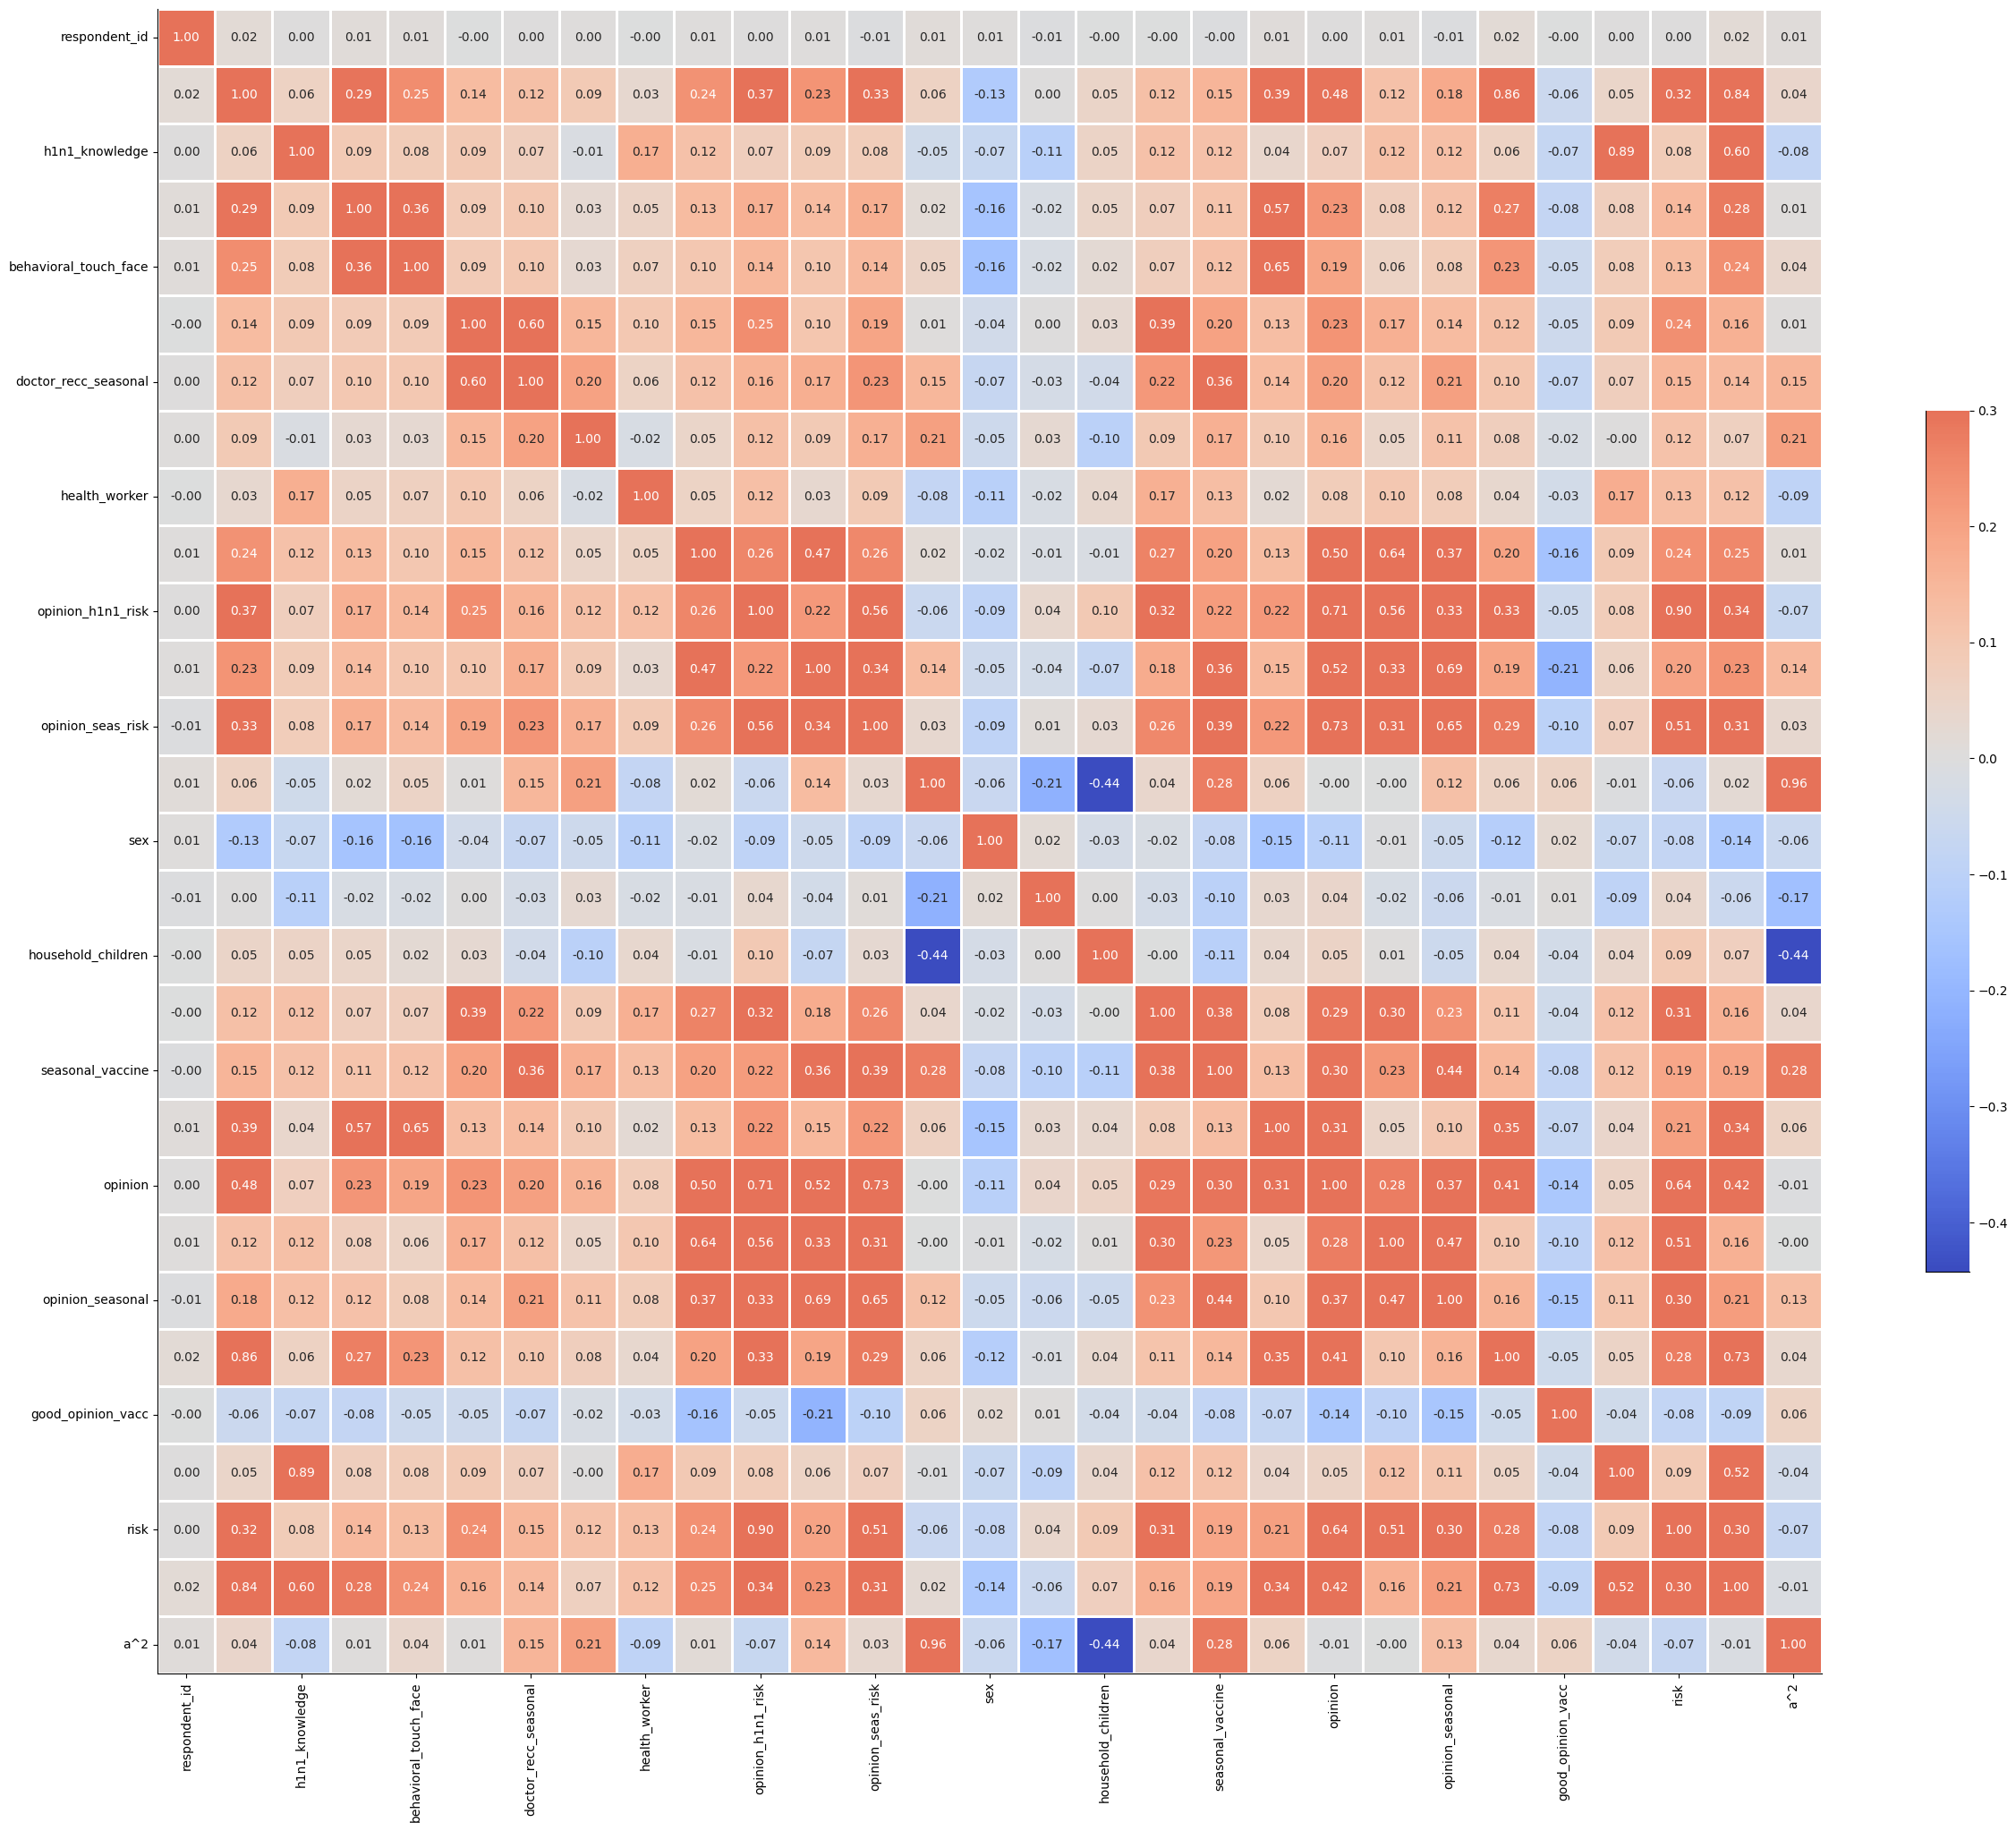

In [53]:
corr = data.corr()
g = sns.heatmap(corr,  vmax=.3, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='coolwarm')
sns.despine()
g.figure.set_size_inches(30,25)
    
plt.show()

In [54]:
#### Appending Y labels to the end of the dataframe ####

data.drop(['respondent_id','h1n1_vaccine','seasonal_vaccine'],axis=1,inplace = True)
frames =[data,Y_label]
data = pd.concat(frames,axis=1)

In [55]:
data.head()

h1n1_concern  h1n1_knowledge  behavioral_wash_hands  behavioral_touch_face  \
0           1.0             0.0                    0.0                    1.0   
1           3.0             2.0                    1.0                    1.0   
2           1.0             1.0                    0.0                    0.0   
3           1.0             1.0                    1.0                    0.0   
4           2.0             1.0                    1.0                    1.0   

   doctor_recc_h1n1  doctor_recc_seasonal  chronic_med_condition  \
0               0.0                   0.0                    0.0   
1               0.0                   0.0                    0.0   
2               0.0                   0.0                    1.0   
3               0.0                   1.0                    1.0   
4               0.0                   0.0                    0.0   

   health_worker  opinion_h1n1_vacc_effective  opinion_h1n1_risk  ...  \
0            0.0                          3.0                1.0  ...   
1            0.0                          5.0                4.0  ...   
2            0.0                          3.0                1.0  ...   
3            0.0                          3.0                3.0  ...   
4            0.0                          3.0                3.0  ...   

   opinion_h1n1  opinion_seasonal  concern>=2  good_opinion_vacc  \
0           2.0               1.0           0                  0   
1           5.0               2.0           1                  0   
2           3.0               3.0           0                  0   
3           1.0               8.0           0                  0   
4           4.0               0.0           1                  1   

   good_knowledge  risk  concern_knowledge  a^2  h1n1_vaccine  \
0               0     0                1.0    9             0   
1               1     1                5.0    1             0   
2               0     0                2.0    0             0   
3               0     0                2.0   16             0   
4               0     0                3.0    4             0   

   seasonal_vaccine  
0                 0  
1                 1  
2                 0  
3                 1  
4                 0  

[5 rows x 28 columns]

In [56]:
features = data.columns[:-2]
print(features)
labels = ['h1n1_vaccine', 'seasonal_vaccine']

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_wash_hands',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'health_worker', 'opinion_h1n1_vacc_effective',
       'opinion_h1n1_risk', 'opinion_seas_vacc_effective', 'opinion_seas_risk',
       'age_group', 'sex', 'rent_or_own', 'household_children', 'cleanliness',
       'opinion', 'opinion_h1n1', 'opinion_seasonal', 'concern>=2',
       'good_opinion_vacc', 'good_knowledge', 'risk', 'concern_knowledge',
       'a^2'],
      dtype='object')


In [57]:
train,test = train_test_split(data,test_size = 0.2,shuffle = True)
train_x,train_y = train[features],train[labels]
test_x,test_y = test[features],test[labels]

In [58]:
train_x.head()

h1n1_concern  h1n1_knowledge  behavioral_wash_hands  \
11560           2.0             2.0                    1.0   
22204           1.0             1.0                    1.0   
17424           2.0             1.0                    1.0   
24316           2.0             1.0                    1.0   
14440           2.0             1.0                    1.0   

       behavioral_touch_face  doctor_recc_h1n1  doctor_recc_seasonal  \
11560                    1.0               0.0                   0.0   
22204                    1.0               0.0                   0.0   
17424                    0.0               0.0                   0.0   
24316                    1.0               0.0                   1.0   
14440                    1.0               1.0                   1.0   

       chronic_med_condition  health_worker  opinion_h1n1_vacc_effective  \
11560                    0.0            0.0                          5.0   
22204                    1.0            0.0                          4.0   
17424                    0.0            0.0                          2.0   
24316                    1.0            0.0                          5.0   
14440                    1.0            0.0                          5.0   

       opinion_h1n1_risk  ...  cleanliness  opinion  opinion_h1n1  \
11560                2.0  ...          4.0     20.0           5.0   
22204                2.0  ...          2.0     14.0           5.0   
17424                2.0  ...          2.0     14.0           2.0   
24316                2.0  ...          3.0     23.0           3.0   
14440                4.0  ...          3.0     21.0           7.0   

       opinion_seasonal  concern>=2  good_opinion_vacc  good_knowledge  risk  \
11560               7.0           1                  0               1     0   
22204               5.0           0                  0               0     0   
17424               4.0           1                  0               0     0   
24316               4.0           1                  0               0     0   
14440               6.0           1                  0               0     1   

       concern_knowledge  a^2  
11560                4.0    9  
22204                2.0    1  
17424                3.0    4  
24316                3.0    1  
14440                3.0    0  

[5 rows x 26 columns]

In [59]:
train_y.head()

h1n1_vaccine  seasonal_vaccine
11560             1                 1
22204             0                 0
17424             0                 0
24316             1                 1
14440             1                 1

In [60]:
train_x.columns

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_wash_hands',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'health_worker', 'opinion_h1n1_vacc_effective',
       'opinion_h1n1_risk', 'opinion_seas_vacc_effective', 'opinion_seas_risk',
       'age_group', 'sex', 'rent_or_own', 'household_children', 'cleanliness',
       'opinion', 'opinion_h1n1', 'opinion_seasonal', 'concern>=2',
       'good_opinion_vacc', 'good_knowledge', 'risk', 'concern_knowledge',
       'a^2'],
      dtype='object')

In [61]:
def transform_test(Test_X):
    Test_X.drop(['respondent_id','health_insurance','employment_industry','employment_occupation'],axis=1,inplace = True)

    # All the NULL values are populated with the mode
            
    d = Test_X
    str_cols = d.select_dtypes(include = 'object').columns

    ### LabelEcoding all categorical types #####
    for col in Test_X.columns:
        if Test_X[col].isnull().sum() and Test_X[col].dtypes != 'object':
            Test_X[col].loc[(Test_X[col].isnull())] = Test_X[col].median()
    for col in Test_X.columns:
        if Test_X[col].isnull().sum() and Test_X[col].dtypes == 'object':
            Test_X[col].loc[(Test_X[col].isnull())] = Test_X[col].mode().max()
    LE = LabelEncoder()
    for col in str_cols:
        Test_X[col] = LE.fit_transform(Test_X[col]) # Converts to int64
            
    data = d
    ### Synthesizing two new features cleanliness level of the individual and opinion of vaccine ####
    data['opinion'] = data['opinion_h1n1_vacc_effective'] + data['opinion_h1n1_risk']+\
                  data['opinion_h1n1_sick_from_vacc'] + data['opinion_seas_vacc_effective']+\
                  data['opinion_seas_risk'] + data['opinion_seas_sick_from_vacc']
    data['cleanliness'] =  data['behavioral_antiviral_meds']+ data['behavioral_avoidance']+\
                        data['behavioral_face_mask']+data['behavioral_wash_hands']+\
                       data['behavioral_large_gatherings'] + data['behavioral_outside_home']+\
                       data['behavioral_touch_face']
    data['opinion_h1n1'] = data['opinion_h1n1_vacc_effective'] + data['opinion_h1n1_risk']-\
                      data['opinion_h1n1_sick_from_vacc'] 
    data['opinion_seasonal'] = data['opinion_seas_vacc_effective']+\
                      data['opinion_seas_risk'] - data['opinion_seas_sick_from_vacc']

    data['concern>=2'] = np.where(data['h1n1_concern']>=2,1,0)
    data['good_opinion_vacc'] = np.where(data['opinion_seas_vacc_effective'] == 3,1,0) # 5 before
    data['good_knowledge'] = np.where(data['h1n1_knowledge'] == 2,1,0)
    data['risk'] = np.where(data['opinion_h1n1_risk']>=4,1,0)
    data['concern_knowledge'] = data['h1n1_concern']+data['h1n1_knowledge']
    data['a^2'] = data['age_group']*data['age_group']
    ###### Dropping other features #########
    data.drop(['race','child_under_6_months','opinion_h1n1_sick_from_vacc','opinion_seas_sick_from_vacc','household_adults','behavioral_antiviral_meds','behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_antiviral_meds','marital_status',
           'behavioral_avoidance','behavioral_face_mask','income_poverty','hhs_geo_region','employment_status','education','census_msa'],axis=1,inplace = True)
    Test_X = data
    return Test_X

In [62]:
Test_X = pd.read_csv('test_set_features.csv')
Test_X.shape

(26708, 36)

In [63]:
Test_X = transform_test(Test_X)

In [64]:
Test_X.isnull().sum()

h1n1_concern                   0
h1n1_knowledge                 0
behavioral_wash_hands          0
behavioral_touch_face          0
doctor_recc_h1n1               0
doctor_recc_seasonal           0
chronic_med_condition          0
health_worker                  0
opinion_h1n1_vacc_effective    0
opinion_h1n1_risk              0
opinion_seas_vacc_effective    0
opinion_seas_risk              0
age_group                      0
sex                            0
rent_or_own                    0
household_children             0
opinion                        0
cleanliness                    0
opinion_h1n1                   0
opinion_seasonal               0
concern>=2                     0
good_opinion_vacc              0
good_knowledge                 0
risk                           0
concern_knowledge              0
a^2                            0
dtype: int64

In [65]:
Test_X.columns

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_wash_hands',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'health_worker', 'opinion_h1n1_vacc_effective',
       'opinion_h1n1_risk', 'opinion_seas_vacc_effective', 'opinion_seas_risk',
       'age_group', 'sex', 'rent_or_own', 'household_children', 'opinion',
       'cleanliness', 'opinion_h1n1', 'opinion_seasonal', 'concern>=2',
       'good_opinion_vacc', 'good_knowledge', 'risk', 'concern_knowledge',
       'a^2'],
      dtype='object')

In [66]:
train_x.columns

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_wash_hands',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'health_worker', 'opinion_h1n1_vacc_effective',
       'opinion_h1n1_risk', 'opinion_seas_vacc_effective', 'opinion_seas_risk',
       'age_group', 'sex', 'rent_or_own', 'household_children', 'cleanliness',
       'opinion', 'opinion_h1n1', 'opinion_seasonal', 'concern>=2',
       'good_opinion_vacc', 'good_knowledge', 'risk', 'concern_knowledge',
       'a^2'],
      dtype='object')

In [67]:
Test_X.head()

h1n1_concern  h1n1_knowledge  behavioral_wash_hands  behavioral_touch_face  \
0           2.0             2.0                    1.0                    1.0   
1           1.0             1.0                    0.0                    0.0   
2           2.0             2.0                    1.0                    1.0   
3           1.0             1.0                    0.0                    0.0   
4           3.0             1.0                    1.0                    1.0   

   doctor_recc_h1n1  doctor_recc_seasonal  chronic_med_condition  \
0               0.0                   0.0                    0.0   
1               0.0                   0.0                    0.0   
2               0.0                   0.0                    0.0   
3               1.0                   1.0                    1.0   
4               0.0                   0.0                    0.0   

   health_worker  opinion_h1n1_vacc_effective  opinion_h1n1_risk  ...  \
0            0.0                          5.0                1.0  ...   
1            0.0                          4.0                1.0  ...   
2            0.0                          5.0                4.0  ...   
3            0.0                          4.0                2.0  ...   
4            1.0                          5.0                2.0  ...   

   opinion  cleanliness  opinion_h1n1  opinion_seasonal  concern>=2  \
0     14.0          4.0           5.0               5.0           1   
1     12.0          0.0           4.0               4.0           0   
2     24.0          5.0           7.0               5.0           1   
3     18.0          0.0           4.0               6.0           0   
4     21.0          6.0           3.0               6.0           1   

   good_opinion_vacc  good_knowledge  risk  concern_knowledge  a^2  
0                  0               1     0                4.0    1  
1                  0               0     0                2.0    0  
2                  0               1     1                4.0    9  
3                  0               0     0                2.0   16  
4                  0               0     0                4.0    1  

[5 rows x 26 columns]

In [68]:
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    #gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    #svm.SVC(probability=True),
    #svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()    
    ]



#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = data['h1n1_vaccine']

#index through MLA and save performance to table
row_index = 0
data1 = data.copy()
for alg in MLA:
    data = data1
    #set name and parameters
    MLA_name = alg.__class__.__name__
    print('Executing ',MLA_name)
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, data[features], data['h1n1_vaccine'], cv  = cv_split)
    #print(cv_results.keys())
    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    #MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    
    #save MLA predictions - see section 6 for usage
    alg.fit(data[features], data['h1n1_vaccine'])
    MLA_predict[MLA_name] = alg.predict(data[features])
    row_index+=1

    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare
#MLA_predict

Executing  AdaBoostClassifier
Executing  BaggingClassifier
Executing  ExtraTreesClassifier
Executing  GradientBoostingClassifier
Executing  RandomForestClassifier
Executing  LogisticRegressionCV
Executing  PassiveAggressiveClassifier
Executing  RidgeClassifierCV
Executing  SGDClassifier
Executing  Perceptron
Executing  BernoulliNB
Executing  GaussianNB


Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7f255249f550>
Traceback (most recent call last):
  File "/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/threadpoolctl.py", line 584, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/threadpoolctl.py", line 725, in _make_controller_from_path
    lib_controller = lib_controller_class(
  File "/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/threadpoolctl.py", line 842, in __init__
    super().__init__(**kwargs)
  File "/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/threadpoolctl.py", line 810, in __init__
    self._dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.8/ctypes/__init__.py", line 373, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /home/eilhie/dasci/DaSci/lib/python3.8/site-pac

Executing  KNeighborsClassifier
Executing  LinearSVC
Executing  DecisionTreeClassifier
Executing  ExtraTreeClassifier
Executing  LinearDiscriminantAnalysis
Executing  QuadraticDiscriminantAnalysis
Executing  XGBClassifier


MLA Name  \
3      GradientBoostingClassifier   
5            LogisticRegressionCV   
0              AdaBoostClassifier   
16     LinearDiscriminantAnalysis   
7               RidgeClassifierCV   
18                  XGBClassifier   
4          RandomForestClassifier   
2            ExtraTreesClassifier   
13                      LinearSVC   
1               BaggingClassifier   
6     PassiveAggressiveClassifier   
10                    BernoulliNB   
12           KNeighborsClassifier   
9                      Perceptron   
8                   SGDClassifier   
15            ExtraTreeClassifier   
14         DecisionTreeClassifier   
11                     GaussianNB   
17  QuadraticDiscriminantAnalysis   

                                       MLA Parameters MLA Test Accuracy Mean  \
3   {'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...               0.835605   
5   {'Cs': 10, 'class_weight': None, 'cv': None, '...               0.833995   
0   {'algorithm': 'SAMME.R', 'base_estimator': 'de...               0.832722   
16  {'covariance_estimator': None, 'n_components':...               0.830388   
7   {'alphas': (0.1, 1.0, 10.0), 'class_weight': N...                0.82899   
18  {'objective': 'binary:logistic', 'use_label_en...               0.827281   
4   {'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...                0.82612   
2   {'bootstrap': False, 'ccp_alpha': 0.0, 'class_...               0.820779   
13  {'C': 1.0, 'class_weight': None, 'dual': True,...               0.815175   
1   {'base_estimator': 'deprecated', 'bootstrap': ...               0.812442   
6   {'C': 1.0, 'average': False, 'class_weight': N...               0.802671   
10  {'alpha': 1.0, 'binarize': 0.0, 'class_prior':...                0.80131   
12  {'algorithm': 'auto', 'leaf_size': 30, 'metric...               0.800037   
9   {'alpha': 0.0001, 'class_weight': None, 'early...               0.782578   
8   {'alpha': 0.0001, 'average': False, 'class_wei...               0.769849   
15  {'ccp_alpha': 0.0, 'class_weight': None, 'crit...               0.756421   
14  {'ccp_alpha': 0.0, 'class_weight': None, 'crit...               0.751017   
11           {'priors': None, 'var_smoothing': 1e-09}               0.748084   
17  {'priors': None, 'reg_param': 0.0, 'store_cova...               0.728254   

   MLA Test Accuracy 3*STD   MLA Time  
3                 0.007533    2.19356  
5                 0.007796   7.830717  
0                 0.003688   0.692777  
16                0.009794   0.105733  
7                 0.007409   0.134225  
18                0.010156  15.169912  
4                 0.007942   1.758332  
2                  0.00681   2.025367  
13                0.040392   3.299794  
1                 0.012635   0.654208  
6                 0.042716   0.082941  
10                0.008895   0.082494  
12                0.009049   0.009959  
9                 0.246944   0.070944  
8                 0.304997   0.481766  
15                0.011175   0.028056  
14                0.013558    0.10556  
11                0.011062   0.019286  
17                0.106959   0.046811

Text(0, 0.5, 'Algorithm')

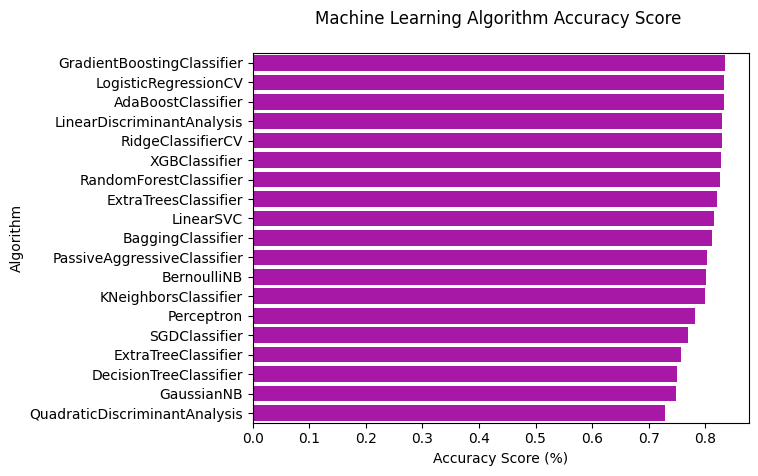

In [69]:
#barplot using https://seaborn.pydata.org/generated/seaborn.barplot.html
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

In [70]:
#### Utility Function to print the accuracy of the model ###

def find_acc(clf,X,truth,s):
    pred = clf.predict_proba(X.values)
    pred = pred.toarray()
    accuracy = roc_auc_score(truth,pred)
    print(s+" Accuracy is : ",accuracy*100)

In [71]:
#### Random Forest Classifier with Grid Search CV for HPO #####

from sklearn.model_selection import GridSearchCV
grid_1 = {      "n_estimators"      : [100,200,500],
               "criterion"         : ["gini", "entropy"],
               "max_features"      : ['sqrt','log2',0.2,0.5,0.8],
               "max_depth"         : [3,4,6,10],
               "min_samples_split" : [2, 5, 20,50] }
RF=RandomForestClassifier()
gs = GridSearchCV(RF, grid_1, n_jobs=-1, cv=2,verbose = True)

In [72]:
clf = BinaryRelevance(classifier=gs, require_dense=[True,True])
clf.fit(train_x,train_y)
find_acc(clf,train_x,train_y,'Training')
find_acc(clf,test_x,test_y,'Cross Validation')

Fitting 2 folds for each of 480 candidates, totalling 960 fits
Fitting 2 folds for each of 480 candidates, totalling 960 fits
Training Accuracy is :  88.55733675152338
Cross Validation Accuracy is :  83.80606112827155


In [73]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [100,200,500]
max_features = ['auto', 'sqrt']
max_depth = [15,20,25]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf = RF
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20,\
                               cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [74]:
clf = BinaryRelevance(classifier=rf_random, require_dense=[True,True])
clf.fit(train_x,train_y)
find_acc(clf,train_x,train_y,'Training')
find_acc(clf,test_x,test_y,'Cross Validation')

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it 

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.8s
[CV] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.9s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.0s


/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it 

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.1s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.1s


/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.4s
[CV] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.5s


/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.8s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.5s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.9s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   5.0s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   8.8s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   8.9s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   9.3s
[CV] END bootstrap=True, max_d

/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.2s


/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   7.1s
[CV] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   7.4s
[CV] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   7.1s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   6.9s


/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   7.8s


/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   8.6s


/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  24.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   8.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   8.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   8.9s


/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  25.7s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  26.6s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  26.5s


/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  27.6s
[CV] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.7s


/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  27.6s
[CV] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.7s


/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.1s


/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  10.0s


/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.2s


/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.1s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.1s


/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  10.7s


/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  11.3s


/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.1s
[CV] END bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   4.0s
[CV] END bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.5s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   9.9s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   9.7s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  10.2s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   7.7s
[CV] END bootstrap=False, max_depth=20

/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it 

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.3s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.5s


/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   3.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.6s
[CV] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.7s


/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it 

[CV] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.9s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   4.0s


/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   4.1s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   9.2s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   9.4s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   9.5s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   5.6s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   6.0s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   6.2s
[CV] END bootstrap=True, max_d

/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.5s


/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   7.3s
[CV] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.4s


/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   6.9s
[CV] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   7.2s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   7.2s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   7.0s


/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   6.9s


/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   7.4s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  25.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   8.0s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  25.2s


/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   7.3s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  25.9s


/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  26.4s


/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.1s


/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.0s
[CV] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.1s


/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  28.4s


/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=  29.3s


/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.1s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.4s


/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   9.0s


/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   3.3s


/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   9.7s


/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=False, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   9.7s


/home/eilhie/dasci/DaSci/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.1s
[CV] END bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   3.0s
[CV] END bootstrap=True, max_depth=15, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.8s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   9.3s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   9.5s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   9.3s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   7.4s
[CV] END bootstrap=True, max_depth=Non

In [75]:
## Neural Network based Classifier on Keras sample ##

def NN_classifier(input_dim,output_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(25,input_dim=input_dim,activation = 'relu'),
        tf.keras.layers.Dense(128,activation = 'relu'),
        tf.keras.layers.Dense(64,activation = 'relu'),
        tf.keras.layers.Dense(output_dim,activation = 'softmax')
    ])
    model.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
    return model

In [76]:
from sklearn.model_selection import GridSearchCV
param2 = {
            'learning_rate':     [0.01,0.1],
            'max_depth':         [2,3,4],
            'lambda':            [1.0,1.5],
            'subsample':        [0.1,0.2,0.3],
            'colsample_bytree': [0.3,0.5,0.6],
            'min_split_loss' :  [0.01,0.2],
            'min_split_size' : [2,4,6]
        }
classifier = XGBClassifier(feature_names = features,verbose = False)
xgb = GridSearchCV(classifier, param2, n_jobs=-1, cv=2,verbose = True)

In [77]:
### Training & Performance ###
clf = BinaryRelevance(classifier=xgb, require_dense=[True,True])
clf.fit(train_x,train_y)
find_acc(clf,train_x,train_y,'Training')
find_acc(clf,test_x,test_y,'Cross Validation')

Fitting 2 folds for each of 648 candidates, totalling 1296 fits
[22:10:50] WARNING: ../src/learner.cc:767: 
Parameters: { "feature_names", "min_split_size", "verbose" } are not used.
[22:10:50] WARNING: ../src/learner.cc:767: 
Parameters: { "feature_names", "min_split_size", "verbose" } are not used.
[22:10:50] WARNING: ../src/learner.cc:767: 
Parameters: { "feature_names", "min_split_size", "verbose" } are not used.
[22:10:50] WARNING: ../src/learner.cc:767: 
Parameters: { "feature_names", "min_split_size", "verbose" } are not used.



[22:10:50] WARNING: ../src/learner.cc:767: 
Parameters: { "feature_names", "min_split_size", "verbose" } are not used.

[22:10:50] WARNING: ../src/learner.cc:767: 
Parameters: { "feature_names", "min_split_size", "verbose" } are not used.


[22:10:50] WARNING: ../src/learner.cc:767: 
Parameters: { "feature_names", "min_split_size", "verbose" } are not used.

[22:10:50] WARNING: ../src/learner.cc:767: 
Parameters: { "feature_names", "min_split_size", "ve

In [78]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [100,200]
max_features = ['auto', 'sqrt']
max_depth = [2,3,7,5,15,20,25]
max_depth.append(None)
min_samples_split = [0.2,0.3,0.6,1.2,1.5,2.0,3.0,4.0]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = XGBClassifier(feature_names = features,verbose = False)
etc = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20,\
                               cv = 4, verbose=2, random_state=42, n_jobs = -1)

In [79]:
clf = BinaryRelevance(classifier=etc, require_dense=[True,True])
clf.fit(train_x,train_y)
find_acc(clf,train_x,train_y,'Training')
find_acc(clf,test_x,test_y,'Cross Validation')

Fitting 4 folds for each of 20 candidates, totalling 80 fits
[22:15:40] WARNING: ../src/learner.cc:767: 
Parameters: { "bootstrap", "feature_names", "max_features", "min_samples_leaf", "min_samples_split", "verbose" } are not used.

[22:15:40] WARNING: ../src/learner.cc:767: 
Parameters: { "bootstrap", "feature_names", "max_features", "min_samples_leaf", "min_samples_split", "verbose" } are not used.

[22:15:40] WARNING: ../src/learner.cc:767: 
Parameters: { "bootstrap", "feature_names", "max_features", "min_samples_leaf", "min_samples_split", "verbose" } are not used.

[22:15:40] WARNING: ../src/learner.cc:767: 
Parameters: { "bootstrap", "feature_names", "max_features", "min_samples_leaf", "min_samples_split", "verbose" } are not used.
[22:15:40] WARNING: ../src/learner.cc:767: 
Parameters: { "bootstrap", "feature_names", "max_features", "min_samples_leaf", "min_samples_split", "verbose" } are not used.


[22:15:40] WARNING: ../src/learner.cc:767: 
Parameters: { "bootstrap", "feature

In [80]:
cb_hps = {  
            'depth':              [2,3,4,5,7],
            'l2_leaf_reg':        [2,3,5,10],
            'random_seed':        [5,8,10],
            'colsample_bylevel': [0.3,0.5,0.6],
            'n_estimators':      [100,200]
        }

cb = CatBoostClassifier()
cbt = RandomizedSearchCV(estimator = cb, param_distributions = cb_hps, n_iter = 20,\
                               cv = 4, verbose=2, random_state=42, n_jobs = -1)

In [81]:
clf = BinaryRelevance(classifier=cbt, require_dense=[True,True])
clf.fit(train_x,train_y)
find_acc(clf,train_x,train_y,'Training')
find_acc(clf,test_x,test_y,'Cross Validation')

Fitting 4 folds for each of 20 candidates, totalling 80 fits
0:	learn: 0.6773228	total: 65.3ms	remaining: 6.46s
0:	learn: 0.6775267	total: 67.2ms	remaining: 6.65s
0:	learn: 0.6773512	total: 69.5ms	remaining: 6.88s
0:	learn: 0.6730785	total: 81.7ms	remaining: 16.3s
1:	learn: 0.6580187	total: 119ms	remaining: 5.83s
0:	learn: 0.6774833	total: 124ms	remaining: 12.3s
0:	learn: 0.6728716	total: 162ms	remaining: 32.3s
0:	learn: 0.6735272	total: 149ms	remaining: 29.7s
0:	learn: 0.6712237	total: 167ms	remaining: 16.6s
0:	learn: 0.6732874	total: 168ms	remaining: 33.5s
1:	learn: 0.6593782	total: 170ms	remaining: 8.34s
0:	learn: 0.6709507	total: 172ms	remaining: 17s
0:	learn: 0.6710102	total: 172ms	remaining: 17s
1:	learn: 0.6542568	total: 188ms	remaining: 18.6s
1:	learn: 0.6590015	total: 191ms	remaining: 9.34s
2:	learn: 0.6410349	total: 241ms	remaining: 7.79s
2:	learn: 0.6431995	total: 237ms	remaining: 7.66s
3:	learn: 0.6248304	total: 249ms	remaining: 5.97s
2:	learn: 0.6402483	total: 244ms	remain

In [82]:
classifier = CatBoostClassifier(
n_estimators = 300,depth = 5,l2_leaf_reg =0.5,
                                random_seed = 2,colsample_bylevel = 0.9,verbose = False)

In [83]:
clf = BinaryRelevance(classifier=classifier, require_dense=[True,True])
clf.fit(train_x,train_y)
find_acc(clf,train_x,train_y,'Training')
find_acc(clf,test_x,test_y,'Cross Validation')

Training Accuracy is :  85.65970611244879
Cross Validation Accuracy is :  84.15130663206259


In [84]:
submission = clf.predict_proba(Test_X.values)
submission_df = pd.DataFrame.sparse.from_spmatrix(submission)

In [85]:
trial = submission_df
trial['respondent_id'] = trial.index+26707 # Converting the default indices
trial['h1n1_vaccine'] = trial[0].astype('float64') # Data required to be in float64 
trial['seasonal_vaccine'] = trial[1].astype('float64')
trial.set_index('respondent_id') # Make index as respondent_id
trial.drop([0,1],axis=1,inplace=True) # Drop old index axis
submission_df = trial 

In [86]:
submission_df # Check if all OK

respondent_id  h1n1_vaccine  seasonal_vaccine
0              26707      0.100486          0.187008
1              26708      0.050306          0.048873
2              26709      0.432614          0.727187
3              26710      0.482951          0.891928
4              26711      0.285756          0.601758
...              ...           ...               ...
26703          53410      0.314372          0.463482
26704          53411      0.169278          0.376990
26705          53412      0.112410          0.206572
26706          53413      0.081219          0.382850
26707          53414      0.397284          0.560519

[26708 rows x 3 columns]

In [87]:
submission_df.to_csv('submissionrandom.csv',index = False)